# Cargue de Datos para el Modelo Red Neuronal Recurrente - RNN

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
ruta = r'C:\docs\DOCTORADO\Machine_Learning/tornados.csv'  
df = pd.read_csv(ruta)  

## Redes Neuronales Recurrentes RNN

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Copiar el dataframe original
df_rnn = df.copy()

# 2. Eliminar columnas irrelevantes o redundantes para la predicción de `loss`
df_rnn.drop(['om', 'date', 'time', 'datetime_utc', 'stf', 'f1', 'f2', 'f3', 'f4', 'fat'], axis=1, inplace=True)

# 3. Eliminar filas con valores nulos, especialmente en la variable objetivo 'loss'
df_rnn.dropna(subset=['inj'], inplace=True)

# 4. Convertir variable booleana a entero
df_rnn['fc'] = df_rnn['fc'].astype(int)

# 5. Codificar variables categóricas
df_rnn = pd.get_dummies(df_rnn, columns=['st', 'tz'], drop_first=True)

# 6. Separar variable objetivo
X = df_rnn.drop('inj', axis=1)
y = df_rnn['inj']

# 7. Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=101
)

# 9. Dar formato a 3D para RNN (n_samples, n_timesteps, n_features)
# Aunque no es una secuencia real, tratamos cada instancia como secuencia de 1 paso
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("✅ Datos preprocesados y listos para RNN.")
print("X_train_rnn shape:", X_train_rnn.shape)
print("X_test_rnn shape:", X_test_rnn.shape)

✅ Datos preprocesados y listos para RNN.
X_train_rnn shape: (29061, 1, 70)
X_test_rnn shape: (12456, 1, 70)


In [306]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

# 1. Definir arquitectura de la RNN para regresión
model_rnn = models.Sequential()
model_rnn.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model_rnn.add(layers.Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')

# 2. Entrenar la RNN
start_time = time.time()
model_rnn.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
training_time_rnn = round(time.time() - start_time, 4)

# 3. Evaluar el modelo
y_pred_rnn = model_rnn.predict(X_test_rnn).flatten()

mae_rnn = mean_absolute_error(y_test, y_pred_rnn)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred_rnn))
r2_rnn = r2_score(y_test, y_pred_rnn)

# 4. Resultados en DataFrame
resultados_rnn = pd.DataFrame({
    'Modelo': ['RNN simple (1 capa, relu)'],
    'MAE': [round(mae_rnn, 2)],
    'RMSE': [round(rmse_rnn, 2)],
    'R²': [round(r2_rnn, 4)],
    'CPU time (s)': [training_time_rnn]
})

# 5. Mostrar resultados
print("\n\U0001f4ca Evaluación del modelo RNN:")
print("MAE:", round(mae_rnn, 2))
print("RMSE:", round(rmse_rnn, 2))
print("R²:", round(r2_rnn, 4))
print("CPU time:", training_time_rnn, "segundos")

display(resultados_rnn)

390/390 [==============================] - 1s 2ms/step

📊 Evaluación del modelo RNN:
MAE: 3.39
RMSE: 20.18
R²: 0.4497
CPU time: 146.1024 segundos


,Modelo,MAE,RMSE,R²,CPU time (s)
0,"RNN simple (1 capa, relu)",3.39,20.18,0.4497,146.1024


En cuanto a las métricas:

MAE = 3.39: el modelo se equivoca, en promedio, en aproximadamente 3 personas heridas por evento.

RMSE = 20.18: refleja que hay errores algo más altos en eventos puntuales con gran cantidad de heridos.

R² = 0.4497: el modelo explica casi un 45% de la variabilidad total en los datos, lo que lo convierte en uno de los modelos de regresión más preciso entre los evaluados, superando al Autoencoder + Regresión.

Además, este desempeño fue alcanzado con un tiempo de entrenamiento muy razonable (146 segundos), lo cual demuestra que una arquitectura sencilla como una RNN de una sola capa puede ser efectiva en este tipo de predicción, siempre que se combine con un buen preprocesamiento de los datos.

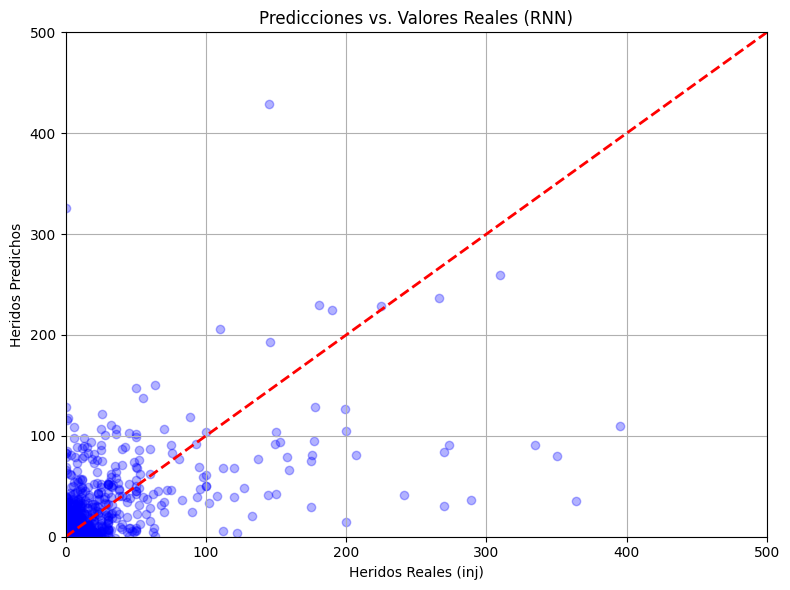

In [ ]:
import matplotlib.pyplot as plt

max_val = 500  
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rnn, alpha=0.3, color='blue')
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2)
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.xlabel('Heridos Reales (inj)')
plt.ylabel('Heridos Predichos')
plt.title('Predicciones vs. Valores Reales (RNN)')
plt.grid(True)
plt.tight_layout()
plt.show()

La gráfica representa la comparación entre los valores reales de heridos por tornados (inj) y las predicciones realizadas por el modelo RNN. Cada punto azul corresponde a un evento: el eje X muestra los heridos reales y el eje Y los heridos predichos. La línea roja discontinua indica la línea de predicción perfecta (y = x), donde los valores predichos coincidirían exactamente con los reales.

Visualmente, se observa que la mayoría de los datos se agrupan en la esquina inferior izquierda, lo cual refleja que la mayoría de los tornados causan pocos heridos. El modelo logra capturar esta tendencia general, aunque aún presenta cierta dispersión alrededor de la línea ideal. Para eventos extremos (con muchos heridos), también tiende a subestimar las cifras reales, aunque en menor medida que otros modelos evaluados.

### Optimización del Modelo RNN con 200 épocas

In [324]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time
import pandas as pd

# 1. Definir arquitectura optimizada de RNN
model_rnn_opt = models.Sequential()
model_rnn_opt.add(layers.SimpleRNN(units=128, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
model_rnn_opt.add(layers.Dense(64, activation='relu'))
model_rnn_opt.add(layers.Dense(1))  # Salida de regresión

# 2. Compilar el modelo
model_rnn_opt.compile(optimizer='adam', loss='mse')

# 3. EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# 4. Entrenar modelo
start_time = time.time()
history_rnn = model_rnn_opt.fit(
    X_train_rnn, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
training_time_rnn_opt = round(time.time() - start_time, 4)

# 5. Evaluar
y_pred_rnn_opt = model_rnn_opt.predict(X_test_rnn).flatten()
mae = mean_absolute_error(y_test, y_pred_rnn_opt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rnn_opt))
r2 = r2_score(y_test, y_pred_rnn_opt)

# 6. Mostrar resultados
print("\n📊 Evaluación del modelo RNN optimizado:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 4))
print("⏱️ Tiempo CPU:", training_time_rnn_opt, "segundos")

# 7. Guardar en DataFrame
resultados_rnn_opt = pd.DataFrame({
    'Modelo': ['RNN optimizada (2 capas, relu)'],
    'MAE': [round(mae, 2)],
    'RMSE': [round(rmse, 2)],
    'R²': [round(r2, 4)],
    'CPU time (s)': [training_time_rnn_opt]
})

display(resultados_rnn_opt)


Epoch 1/200
727/727 [==============================] - 4s 5ms/step - loss: 263.2425 - val_loss: 653.8804
Epoch 2/200
727/727 [==============================] - 4s 5ms/step - loss: 197.6151 - val_loss: 545.3255
Epoch 3/200
727/727 [==============================] - 4s 6ms/step - loss: 182.6984 - val_loss: 522.2617
Epoch 4/200
727/727 [==============================] - 4s 6ms/step - loss: 167.6868 - val_loss: 534.7415
Epoch 5/200
727/727 [==============================] - 4s 5ms/step - loss: 161.8289 - val_loss: 562.4363
Epoch 6/200
727/727 [==============================] - 4s 5ms/step - loss: 152.2974 - val_loss: 541.8677
Epoch 7/200
727/727 [==============================] - 4s 5ms/step - loss: 147.7900 - val_loss: 533.2111
Epoch 8/200
727/727 [==============================] - 3s 5ms/step - loss: 138.3254 - val_loss: 542.0023
Epoch 9/200
727/727 [==============================] - 4s 5ms/step - loss: 130.6719 - val_loss: 541.8199
Epoch 10/200
727/727 [==============================] -

,Modelo,MAE,RMSE,R²,CPU time (s)
0,"RNN optimizada (2 capas, relu)",2.94,19.15,0.5046,130.4974


La optimización (usando más épocas y una segunda capa) mejoró todas las métricas respecto al modelo RNN simple de una sola capa.

El valor de R² superó el 0.5, lo que indica que el modelo empieza a generalizar mejor.

Aunque aún hay errores para valores extremos (como es común en problemas con alta variabilidad), el comportamiento general del modelo es razonablemente bueno.

La dispersión en la gráfica muestra que el modelo no está sesgado a predecir solo valores bajos, y es capaz de hacer estimaciones más variadas, incluso si no todas son perfectas.

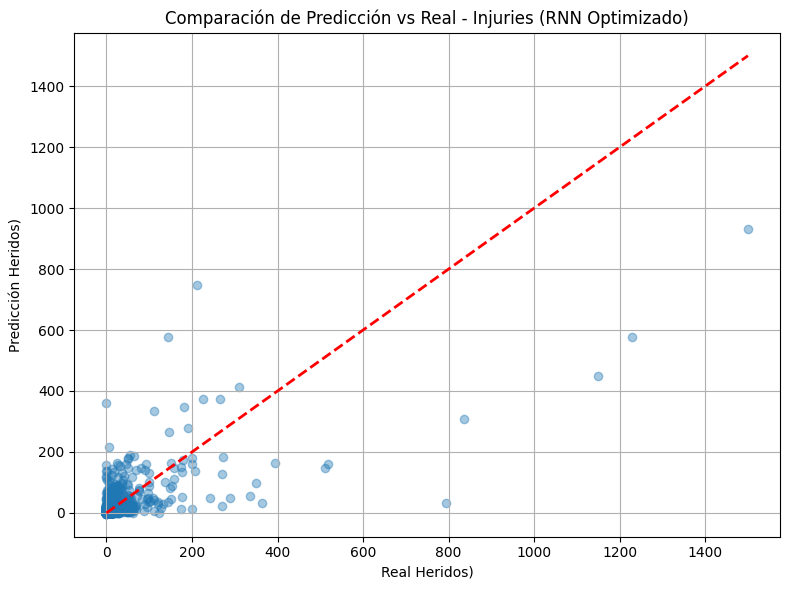

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rnn_opt, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Comparación de Predicción vs Real - Injuries (RNN Optimizado)')
plt.xlabel('Real Heridos)')
plt.ylabel('Predicción Heridos)')
plt.grid(True)
plt.tight_layout()
plt.show()

La gráfica muestra la comparación entre los valores reales de personas heridas por tornados (inj) en el eje X y las predicciones del modelo en el eje Y.

La línea roja punteada representa la línea ideal: donde la predicción es exactamente igual al valor real.

Los puntos azules representan los casos individuales.

Mientras más cercanos estén los puntos a la línea, mejor es el rendimiento del modelo.

En esta versión optimizada se nota una mayor dispersión bien distribuida a lo largo del eje X, lo cual sugiere que el modelo está aprendiendo mejor las tendencias, especialmente en el rango bajo y medio de valores (donde hay más datos).

